# OC PROJET 4 - CLIENT SEGMENTATION
#### CLUSTERING NOTEBOOK
<br></br>
### SOMMAIRE
- <a href="#C1">I. Feature Selection</a>
    - 1. 
    - 2. 
    - 3.
    
- <a href="#C2">II. Clustering</a>
     - 1. 
     - 2.
     - 3. 
     - 4.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import font_manager as fm, rcParams
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as st
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.cluster import hierarchy

<font size="5">Paramétrages Data Visualisation</font>

In [2]:
# Ajouter une ombre à la police
shadow = path_effects.withSimplePatchShadow(offset=(1,-0.75), shadow_rgbFace='darkblue', alpha=0.25)

# Utiliser la police dans les graphiques, changer la couleur et augmenter la résolution d'affichage
plt.rcParams['font.family'] = 'Ebrima'
plt.rcParams['text.color'] = 'white'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.style.use('dark_background')
# set le theme seaborn
sns.set_style('darkgrid', {'axes.facecolor': '0.2','text.color': 'white','figure.figsize': (20, 16)})
plt.rcParams['figure.facecolor'] = '0.2'
# définition des paramètres kwargs typo
text_kwargs = dict(ha='center', va='center', fontsize=10, color='white')

# suppression de l'affichage max des colonnes
pd.set_option('display.max_columns', None)

In [3]:
# chargement du df master et conversion des variables temporelles au format datetime
df = pd.read_csv('olist_master.csv')

df['order_purchase_datetime'] = pd.to_datetime(df['order_purchase_datetime'])
df['order_delivered_datetime'] = pd.to_datetime(df['order_delivered_datetime'])

In [16]:
df.dtypes

customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_id                                 object
order_status                             object
review_score                            float64
product_id                               object
seller_id                                object
price                                   float64
freight_value                           float64
product_category_name_english            object
seller_zip_code_prefix                  float64
seller_city                              object
seller_state                             object
payment_type                             object
payment_installments                    float64
payment_value                           float64
order_purchase_datetime          datetime64[ns]
order_delivered_datetime         datetim

<font size="5">
   Normalisation des variables</font>

In [21]:
# Sélection de toutes les variables à normaliser
to_normalize = ['price', 'freight_value',
'payment_value','days_since_last_purchase', 'delivery_time_days', 'price',
'average_price_cat', 'total_amount_client']

# Création d'un objet StandardScaler
scaler = StandardScaler()

# Normalisation de toutes les variables sélectionnées
df[to_normalize] = scaler.fit_transform(df[to_normalize])

<font size="5">Feature Selection</font>

In [19]:
df.describe()

,customer_zip_code_prefix,review_score,price,freight_value,seller_zip_code_prefix,payment_installments,payment_value,month,year,delivery_time_days,average_price_cat,nb_purchase_last_3_months,total_amount_client,nb_different_product_client,days_since_last_purchase
count,102331.000000,102331.000000,1.023310e+05,1.023310e+05,102331.000000,102331.000000,1.023310e+05,102331.000000,102331.000000,1.023310e+05,1.023310e+05,102331.000000,1.023310e+05,102331.000000,1.023310e+05
mean,35092.930451,4.124762,4.623117e-17,2.448694e-18,24655.469105,2.909324,-1.387304e-16,6.041962,2017.541507,-1.951817e-16,2.395024e-16,0.226676,-9.366500e-17,1.016681,-1.267677e-17
std,29796.573959,1.310700,1.000005e+00,1.000005e+00,27699.065095,2.731772,1.000005e+00,3.221965,0.504107,1.000005e+00,1.000005e+00,0.535079,1.000005e+00,0.131686,1.000005e+00
min,1003.000000,1.000000,-6.623209e-01,-1.274074e+00,1001.000000,0.000000,-7.489752e-01,1.000000,2016.000000,-1.269299e+00,-1.529519e+00,0.000000,-5.324947e-01,1.000000,-1.568825e+00
25%,11340.000000,4.000000,-4.507673e-01,-4.404858e-01,6429.000000,1.000000,-4.711367e-01,3.000000,2017.000000,-6.352378e-01,-4.802219e-01,0.000000,-3.679098e-01,1.000000,-8.116656e-01
50%,24360.000000,5.000000,-2.454280e-01,-2.377895e-01,13720.000000,2.000000,-2.594854e-01,6.000000,2018.000000,-2.125301e-01,-1.022636e-01,0.000000,-2.319371e-01,1.000000,-1.197781e-01
75%,58622.500000,5.000000,8.149379e-02,7.132230e-02,29156.000000,4.000000,9.336208e-02,8.000000,2018.000000,3.158545e-01,1.736815e-01,0.000000,1.175641e-02,1.000000,7.222359e-01
max,99980.000000,5.000000,3.445151e+01,2.467612e+01,99730.000000,24.000000,3.132727e+01,12.000000,2018.000000,2.071150e+01,1.601262e+01,9.000000,4.549049e+01,3.000000,2.967607e+00


In [24]:
# Sélectionner les colonnes pertinentes pour la segmentation client
features = ['review_score', 'product_category_name_english', 'total_amount_client', 
            'payment_installments', 'days_since_last_purchase']

# Créer une nouvelle dataframe avec les colonnes sélectionnées
df_selected = df[features]


# Effectuer la sélection de fonctionnalités
X = df_selected.drop('product_category_name_english', axis=1)  # Variables indépendantes
y = df_selected['product_category_name_english']  # Variable dépendante

# Utiliser le test du chi2 pour sélectionner les K meilleures fonctionnalités
k = 3  # Nombre de fonctionnalités à sélectionner
selector = SelectKBest(chi2, k=k)
X_new = selector.fit_transform(X, y)

# Effectuer la classification non supervisée (segmentation client)
kmeans = KMeans(n_clusters=3)  # Nombre de clusters à former
kmeans.fit(X_new)

# Obtenir les étiquettes des clusters
labels = kmeans.labels_

# Ajouter les étiquettes des clusters au dataframe original
df['cluster_label'] = labels

# Afficher le dataframe avec les étiquettes des clusters
print(df[['review_score', 'product_category_name_english', 'total_amount_client', 'payment_installments',
'days_since_last_purchase', 'cluster_label']])

        review_score product_category_name_english  total_amount_client  \
0                4.0              office_furniture               146.87   
1                5.0                    housewares               335.48   
2                5.0              office_furniture               157.73   
3                5.0              office_furniture               173.30   
4                5.0                  home_confort               252.25   
...              ...                           ...                  ...   
102326           4.0        books_general_interest                88.78   
102327           5.0                sports_leisure               129.06   
102328           1.0                 health_beauty                56.04   
102329           5.0                 watches_gifts               711.07   
102330           5.0                     perfumery                21.77   

        payment_installments  days_since_last_purchase  cluster_label  
0                        2.

In [25]:
selector.feature_names_in_

array(['review_score', 'total_amount_client', 'payment_installments',
       'days_since_last_purchase'], dtype=object)

In [26]:
# Sélectionner les colonnes pertinentes pour la segmentation client
features = ['review_score', 'total_amount_client', 'payment_installments', 'days_since_last_purchase']

# Créer une nouvelle dataframe avec les colonnes sélectionnées
df_selected = df[features]

X = df_selected.values

inertia = []
K_range = range(1,10)
for k in K_range:
    model = KMeans(n_clusters=k).fit(X)
    inertia.append(model.inertia_)

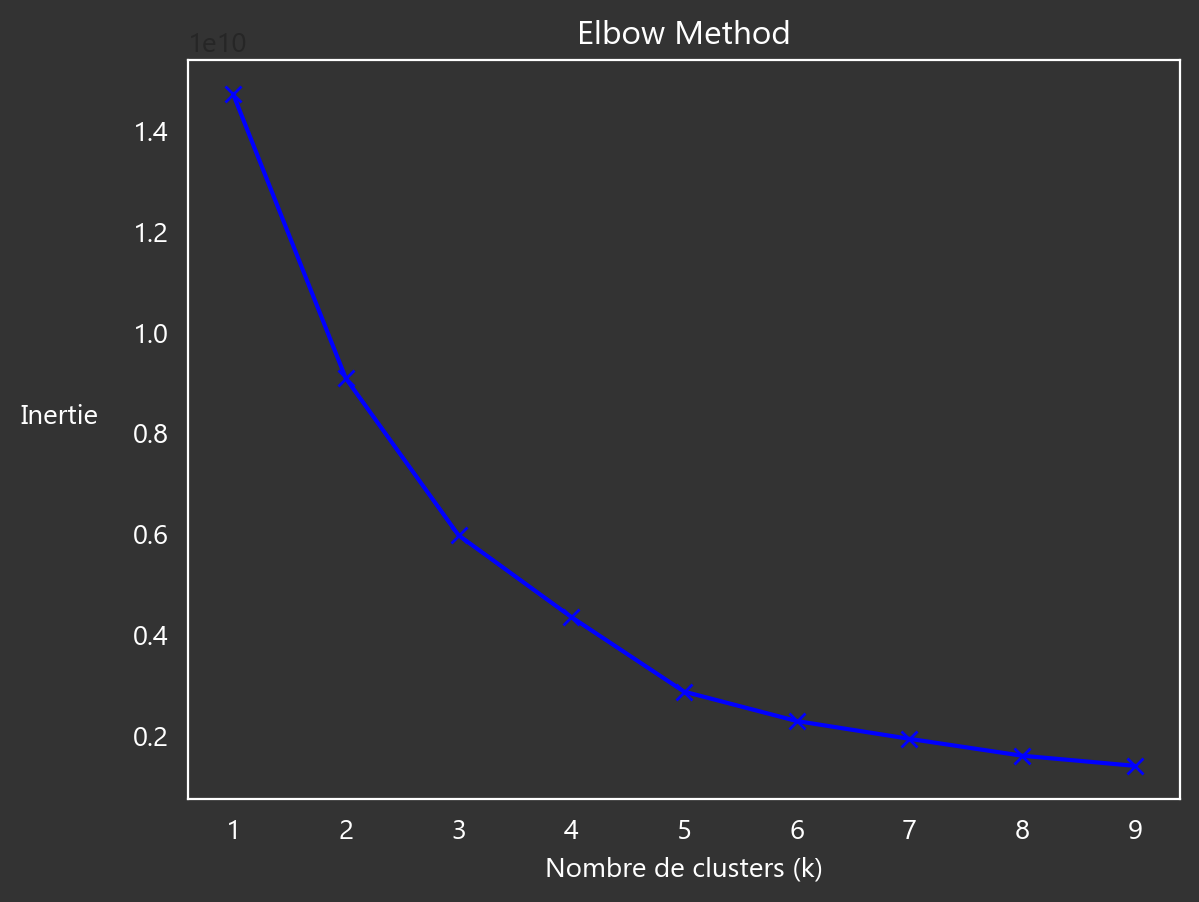

In [105]:
plt.rcParams['font.family'] = 'Ebrima'
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Nombre de clusters (k)', color = 'white')
plt.gca().yaxis.set_label_coords(-0.13, 0.5)
plt.ylabel('Inertie', rotation = 360, color = 'white')
plt.title('Elbow Method')
plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.grid(False)
plt.show()

Nombre de clients par cluster:
3    41302
1    31356
2    16215
0    13409
Name: cluster, dtype: int64


C:\Users\omira\AppData\Local\Temp\ipykernel_10508\3183747588.py:37: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


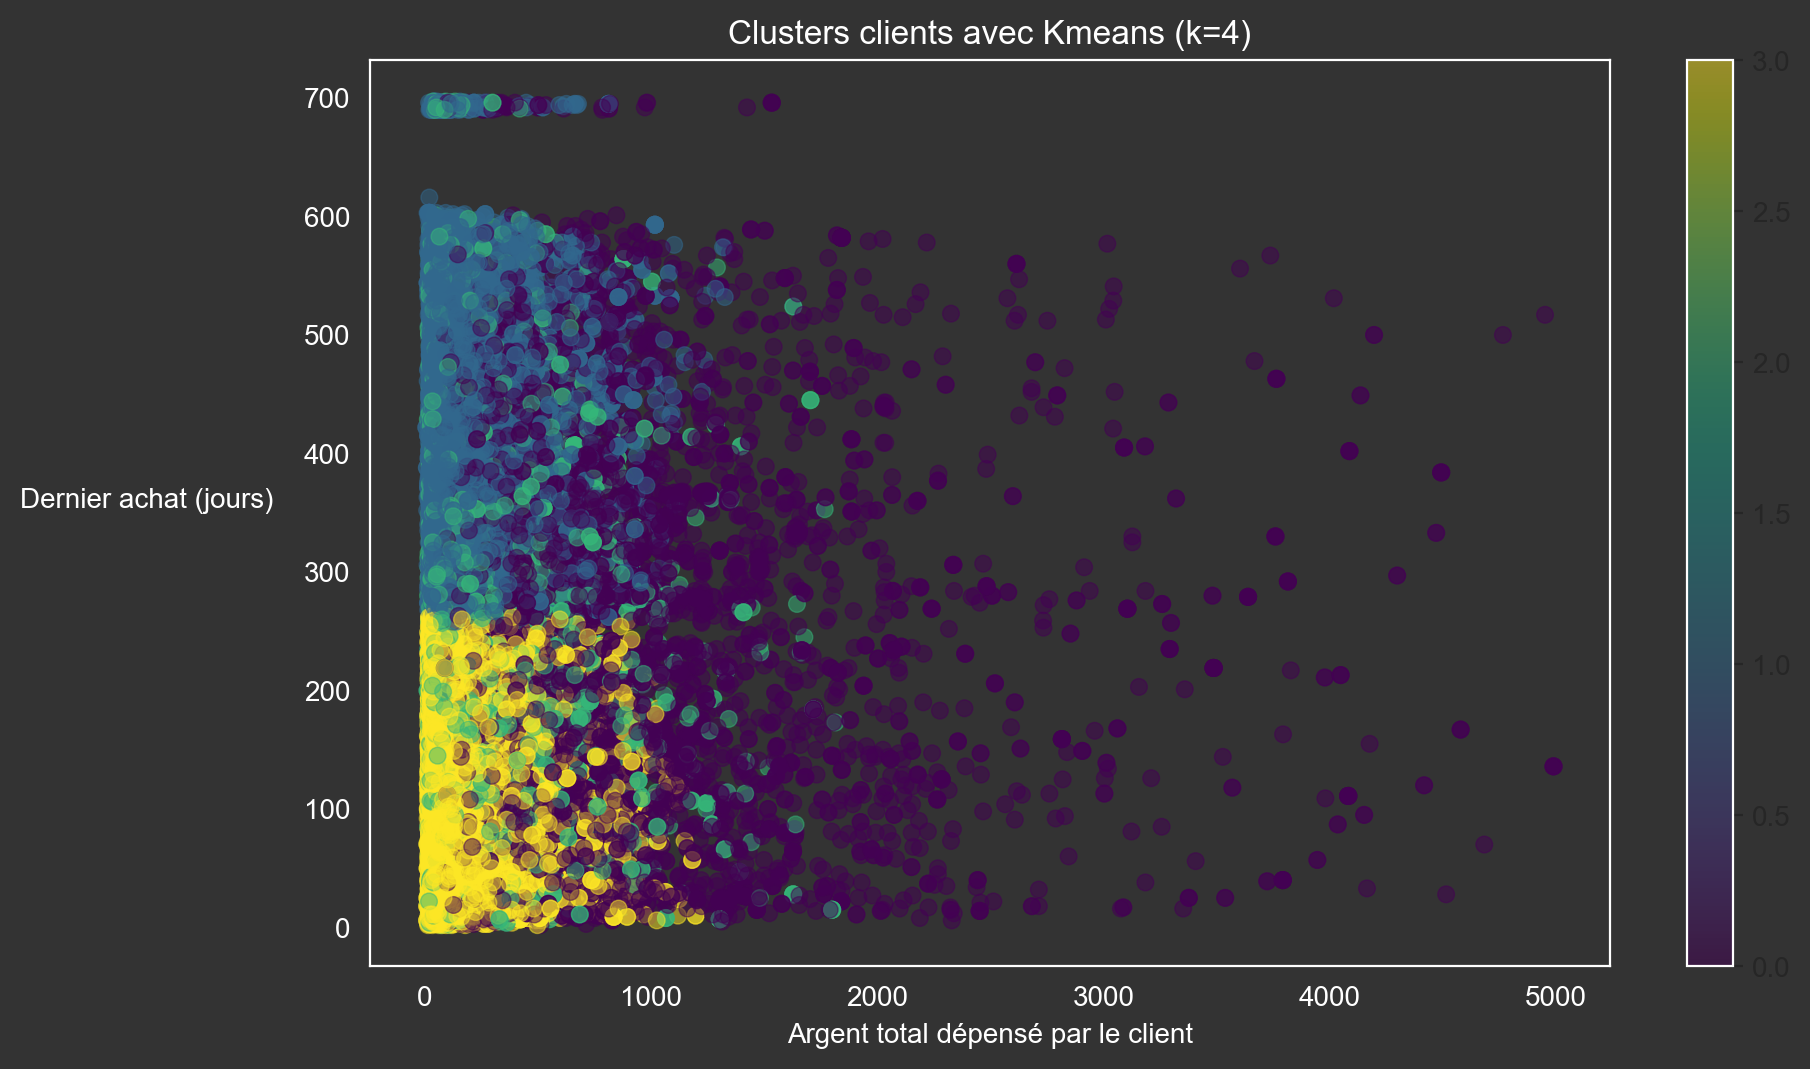

In [4]:
# Chargement des données
data = pd.read_csv('https://raw.githubusercontent.com/random-agile/Client-Segmentation/main/olist_master.csv')

data = data[data['total_amount_client'] <= 6000]

# Sélection des colonnes pertinentes pour la segmentation
selected_columns = ['total_amount_client', 'review_score', 'days_since_last_purchase', 'payment_installments']
X = data[selected_columns]

# Prétraitement des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Application de l'algorithme K-means
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)

# Ajout des étiquettes de clusters au dataframe d'origine
data['cluster'] = kmeans.labels_

# Analyse des clusters
cluster_counts = data['cluster'].value_counts()
print("Nombre de clients par cluster:")
print(cluster_counts)

# Visualisation des clusters
plt.figure(figsize=(10, 6))
plt.scatter(X['total_amount_client'], X['days_since_last_purchase'], alpha=0.5, 
linewidths=0.5, c=kmeans.labels_, cmap='viridis')
plt.xlabel('Argent total dépensé par le client', color = 'white')
plt.gca().yaxis.set_label_coords(-0.18, 0.5)
plt.ylabel('Dernier achat (jours)', color = 'white', rotation = 360)
plt.title('Clusters clients avec Kmeans (k=4)')
plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.grid(False)
plt.colorbar()
plt.show()

Text(0.5, 0, 'Review Score')

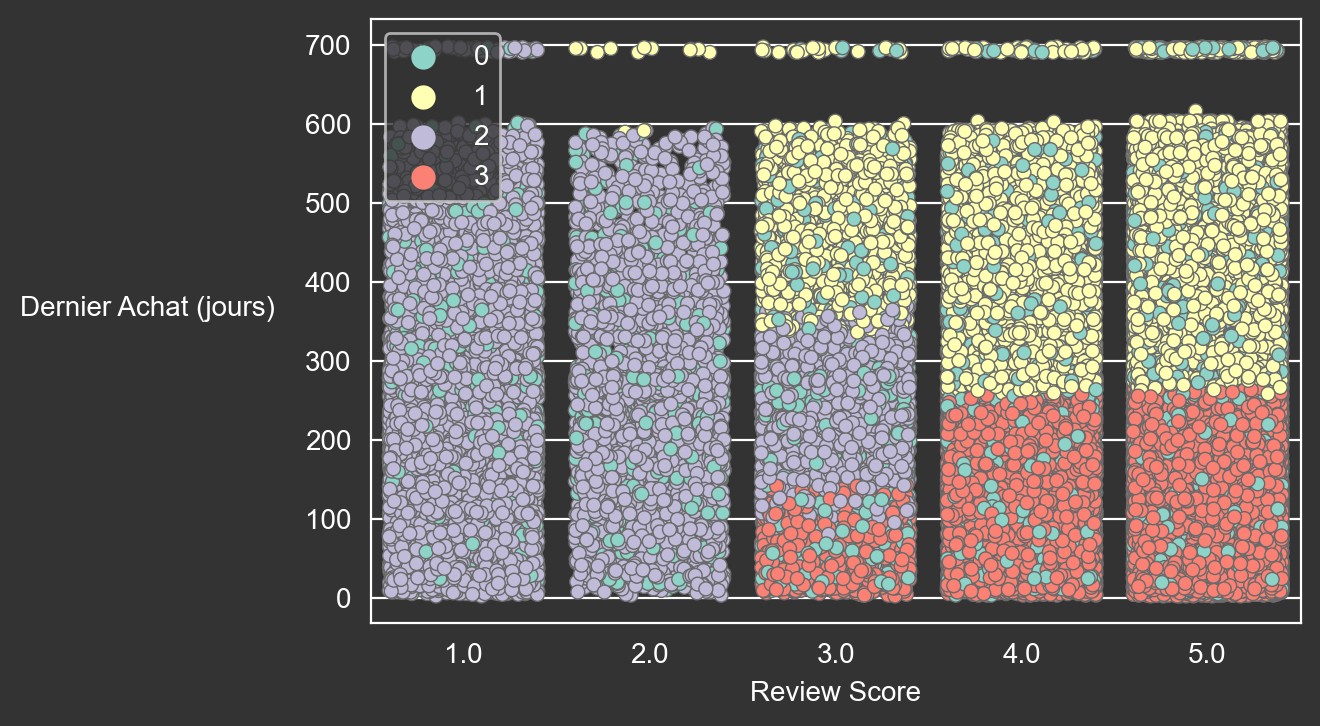

In [5]:
sns.stripplot(data=X, x="review_score", y="days_since_last_purchase", hue=kmeans.labels_, jitter = 0.4, linewidth=0.5)
plt.gca().yaxis.set_label_coords(-0.24, 0.5)
plt.gca().xaxis.label.set_color("white")
plt.gca().yaxis.label.set_color("white")
plt.gca().tick_params(axis="x", colors="white")
plt.gca().tick_params(axis="y", colors="white")
plt.gca().set_ylabel("Dernier Achat (jours)", rotation=360)
plt.gca().set_xlabel("Review Score")

(0.0, 10.0)

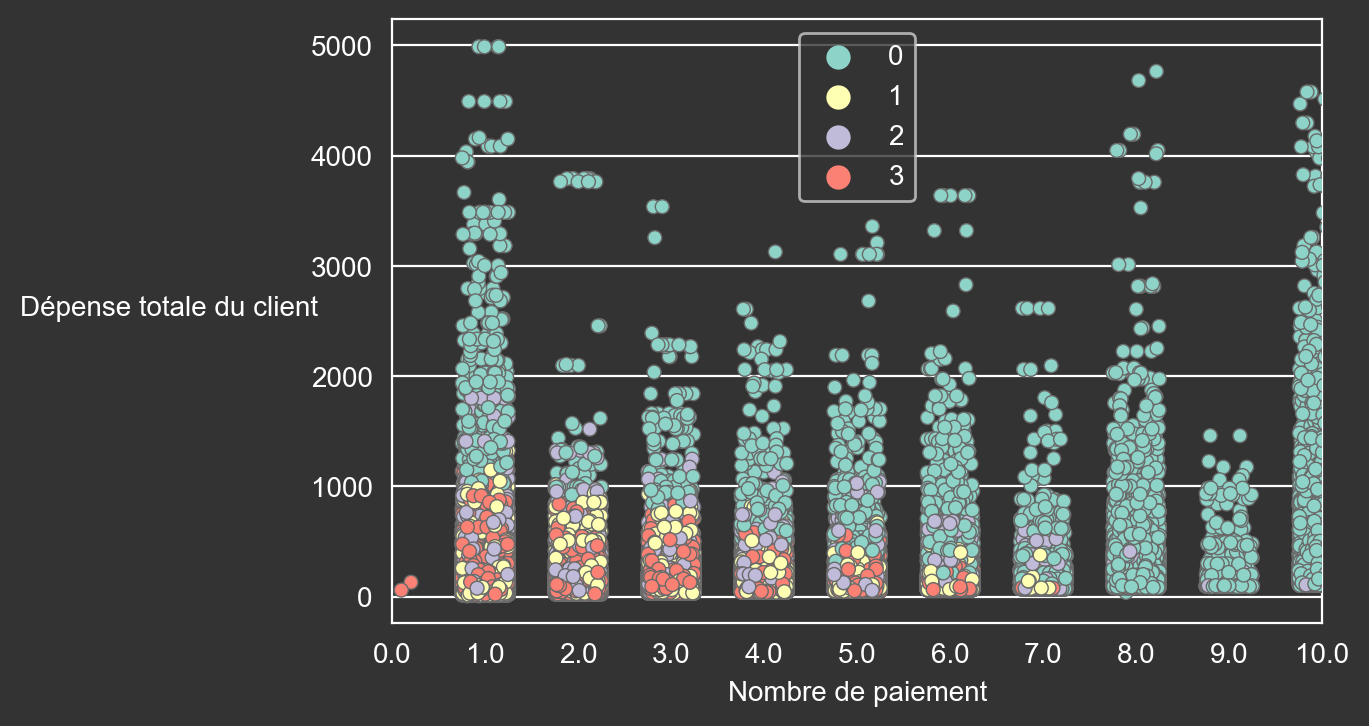

In [12]:
sns.stripplot(data=X, x="payment_installments", y="total_amount_client", hue=kmeans.labels_, jitter = 0.25, linewidth=0.5)
plt.gca().yaxis.set_label_coords(-0.24, 0.5)
plt.gca().xaxis.label.set_color("white")
plt.gca().yaxis.label.set_color("white")
plt.gca().tick_params(axis="x", colors="white")
plt.gca().tick_params(axis="y", colors="white")
plt.gca().set_ylabel("Dépense totale du client", rotation = 360)
plt.gca().set_xlabel("Nombre de paiement")
plt.xlim(0, 10)

# TO DO
Continuez de plotter pour voir les tendances par clusters

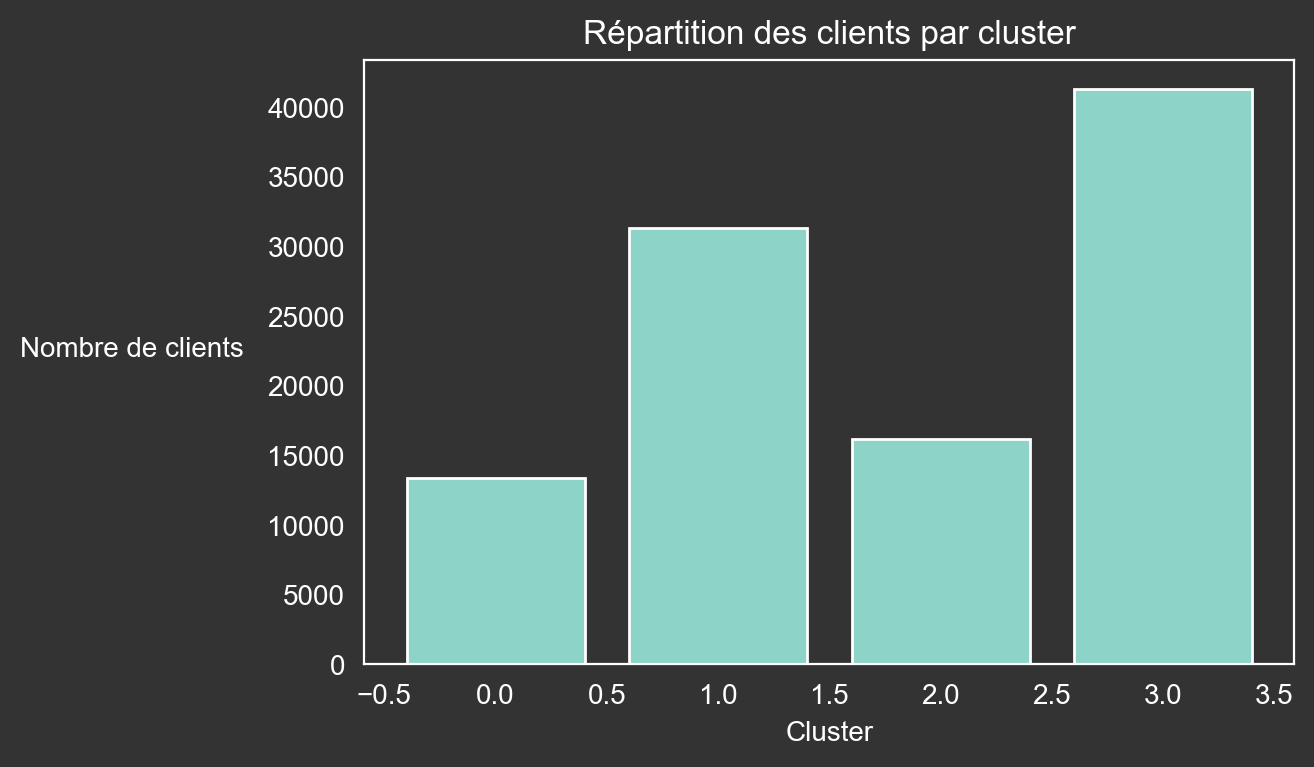

In [13]:
# Afficher la répartition des clusters
cluster_counts = data['cluster'].value_counts().sort_index()
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster', color = 'white')
plt.ylabel('Nombre de clients', color = 'white', rotation = 360)
plt.title('Répartition des clients par cluster')
plt.gca().yaxis.set_label_coords(-0.25, 0.5)
plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.grid(False)
plt.show()

In [14]:
data_cluster = data[selected_columns]
data_cluster['cluster'] = kmeans.labels_
# Calculer les moyennes des variables pour chaque cluster
cluster_means = data_cluster.groupby('cluster').mean()

# Afficher les moyennes des variables pour chaque cluster
print(cluster_means)

         total_amount_client  review_score  days_since_last_purchase  \
cluster                                                                
0                 509.258936      4.203371                248.413901   
1                 129.268245      4.635827                398.170175   
2                 179.386779      1.643355                235.155597   
3                 127.983563      4.687206                124.948041   

         payment_installments  
cluster                        
0                    8.389813  
1                    2.119339  
2                    2.426519  
3                    1.917752  


C:\Users\omira\AppData\Local\Temp\ipykernel_10508\1288811847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cluster['cluster'] = kmeans.labels_


In [27]:
data_cluster.shape

(102282, 5)

In [15]:
# Calculer les moyennes des variables pour chaque cluster
cluster_describe = data_cluster.groupby('cluster').describe()

# Définir la largeur maximale des colonnes de sortie
pd.set_option('display.width', 110)
# Afficher les moyennes des variables pour chaque cluster
print(cluster_describe)

        total_amount_client                                                                   review_score  \
                      count        mean         std    min      25%     50%      75%      max        count   
cluster                                                                                                      
0                   13409.0  509.258936  580.550903  37.58  168.200  302.10  618.600  4987.88      13409.0   
1                   31356.0  129.268245  122.481030   6.15   57.075   92.30  155.125  1325.32      31356.0   
2                   16215.0  179.386779  190.602374  11.54   66.670  117.58  210.070  1814.29      16215.0   
3                   41302.0  127.983563  117.402592   9.59   56.390   94.72  158.070  1196.50      41302.0   

                                                     days_since_last_purchase                          \
             mean       std  min  25%  50%  75%  max                    count        mean         std   
cluster            

In [21]:
# Obtenir les coordonnées des centroïdes
centroids = kmeans.cluster_centers_

# Assigner les clusters aux données
df['cluster'] = kmeans.labels_

# Créer une liste de couleurs pour les points de données
colors = ['blue', 'green', 'purple']

# Tracer les points de données
plt.scatter(df_normalized[:, 0], df_normalized[:, 2], c=df['cluster'], cmap='viridis', alpha=0.5)

# Tracer les centroïdes
plt.scatter(centroids[:, 0], centroids[:, 2], marker='o', s=50, color='r')
plt.gca().yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel('Feature 1', color = 'white')
plt.ylabel('Feature 2', color = 'white', rotation = 360)
plt.title('Clusters des données avec les centroïdes')
plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.grid(False)
plt.show()

ValueError: Length of values (102282) does not match length of index (102084)

In [9]:
data = [
    {'r': 13.10/10, 'theta': 'Taille (13.1%)'},
    {'r': 4.20, 'theta': 'Review (4.2★)'},
    {'r': 248.41/100, 'theta': 'Dernier Achat (248j)'},
    {'r': 8.38/2, 'theta': 'Nombre de paiment (x8.3)'},
    {'r': 500/100, 'theta': 'Dépense totale (509.25BRL)'},
]

fig = px.line_polar(data, r='r', theta='theta',title="Caractéristiques Cluster 1",
line_close=True, template='plotly_dark', color_discrete_sequence=['turquoise'])
fig.update_traces(fill='toself')
# change la police
fig.update_layout(
    font=dict(
        family="Optima",
        size=20,
        color="white"
    )
)

# Masquer la ligne représentant les valeurs de 0 à 5 sur l'axe radial
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            showline=False, # masquer la ligne sur l'axe radial
            range=[0,5], # plage maximale de l'axe radial
            showticklabels=False
        )
    )
)

# changer les couleurs de fond et de la grille
fig.update_layout(
    polar=dict(
        radialaxis=dict(gridcolor='gray', linecolor='gray'),
        angularaxis=dict(gridcolor='gray', linecolor='gray')
    )
)

# Augmenter la résolution du rendu
fig.update_layout(
    autosize=False,
    width=1476,  # Largeur du graphique en pixels
    height=787  # Hauteur du graphique en pixels
)

fig.show()

C:\Users\Oliver\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [10]:
data = [
    {'r': 30.65/10, 'theta': 'Taille (30.6%)'},
    {'r': 4.63, 'theta': 'Review (4.6★)'},
    {'r': 398/100, 'theta': 'Dernier Achat (398j)'},
    {'r': 2.11, 'theta': 'Nombre de paiment (x2.1)'},
    {'r': 129.26/100, 'theta': 'Dépense totale (129.26BRL)'},
]

fig = px.line_polar(data, r='r', theta='theta',title="Caractéristiques Cluster 2",
line_close=True, template='plotly_dark', color_discrete_sequence=['turquoise'])
fig.update_traces(fill='toself')
# change la police
fig.update_layout(
    font=dict(
        family="Optima",
        size=20,
        color="white"
    )
)

# Masquer la ligne représentant les valeurs de 0 à 5 sur l'axe radial
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            showline=False, # masquer la ligne sur l'axe radial
            range=[0,5], # plage maximale de l'axe radial
            showticklabels=False
        )
    )
)

# changer les couleurs de fond et de la grille
fig.update_layout(
    polar=dict(
        radialaxis=dict(gridcolor='gray', linecolor='gray'),
        angularaxis=dict(gridcolor='gray', linecolor='gray')
    )
)

# Augmenter la résolution du rendu
fig.update_layout(
    autosize=False,
    width=1476,  # Largeur du graphique en pixels
    height=787  # Hauteur du graphique en pixels
)

fig.show()

C:\Users\Oliver\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [11]:
data = [
    {'r': 15.82/10, 'theta': 'Taille (15.8%)'},
    {'r': 1.64, 'theta': 'Review (1.6★)'},
    {'r': 235/100, 'theta': 'Dernier Achat (235j)'},
    {'r': 2.42, 'theta': 'Nombre de paiment (x2.4)'},
    {'r': 179.38/100, 'theta': 'Dépense totale (179.38BRL)'},
]

fig = px.line_polar(data, r='r', theta='theta',title="Caractéristiques Cluster 3",
line_close=True, template='plotly_dark', color_discrete_sequence=['turquoise'])
fig.update_traces(fill='toself')
# change la police
fig.update_layout(
    font=dict(
        family="Optima",
        size=20,
        color="white"
    )
)

# Masquer la ligne représentant les valeurs de 0 à 5 sur l'axe radial
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            showline=False, # masquer la ligne sur l'axe radial
            range=[0,5], # plage maximale de l'axe radial
            showticklabels=False
        )
    )
)

# changer les couleurs de fond et de la grille
fig.update_layout(
    polar=dict(
        radialaxis=dict(gridcolor='gray', linecolor='gray'),
        angularaxis=dict(gridcolor='gray', linecolor='gray')
    )
)

# Augmenter la résolution du rendu
fig.update_layout(
    autosize=False,
    width=1476,  # Largeur du graphique en pixels
    height=787  # Hauteur du graphique en pixels
)

fig.show()

C:\Users\Oliver\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [12]:
data = [
    {'r': 40.38/10, 'theta': 'Taille (40.3%)'},
    {'r': 4.68, 'theta': 'Review (4.6★)'},
    {'r': 124/100, 'theta': 'Dernier Achat (124j)'},
    {'r': 1.91, 'theta': 'Nombre de paiment (x1.9)'},
    {'r': 127.98/100, 'theta': 'Dépense totale (127.98BRL)'},
]

fig = px.line_polar(data, r='r', theta='theta',title="Caractéristiques Cluster 4",
line_close=True, template='plotly_dark', color_discrete_sequence=['turquoise'])
fig.update_traces(fill='toself')
# change la police
fig.update_layout(
    font=dict(
        family="Optima",
        size=20,
        color="white"
    )
)

# Masquer la ligne représentant les valeurs de 0 à 5 sur l'axe radial
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            showline=False, # masquer la ligne sur l'axe radial
            range=[0,5], # plage maximale de l'axe radial
            showticklabels=False
        )
    )
)

# changer les couleurs de fond et de la grille
fig.update_layout(
    polar=dict(
        radialaxis=dict(gridcolor='gray', linecolor='gray'),
        angularaxis=dict(gridcolor='gray', linecolor='gray')
    )
)

# Augmenter la résolution du rendu
fig.update_layout(
    autosize=False,
    width=1476,  # Largeur du graphique en pixels
    height=787  # Hauteur du graphique en pixels
)

fig.show()

C:\Users\Oliver\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [13]:
from PIL import Image
import ipywidgets as widgets
from IPython.display import display

# Charger l'image
image_path = 'clusters.png'  # Remplacez par le chemin d'accès à votre image
image = Image.open(image_path)

# Créer un widget Image
image_widget = widgets.Image(value=open(image_path, 'rb').read(), format='jpg')
image_widget.layout.height = f'{image.height}px'
image_widget.layout.width = f'{image.width}px'

# Afficher l'image
display(image_widget)

# /!\ clic droit -> ouvrir dans un nouvel onglet
# pour voir les charts en bonne résolution

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x0b\x88\x00\x00\x06&\x08\x02\x00\x00\x00\xd0?\xf6\xe…

In [ ]:
https://github.com/random-agile/Client-Segmentation/blob/main/olist_master.csv

# TEST AVEC DBSCAN

## SIMULATION 1

In [103]:
# chargement du df master et conversion des variables temporelles au format datetime

df = pd.read_csv('olist_master.csv')

df['order_purchase_datetime'] = pd.to_datetime(df['order_purchase_datetime'])
df['order_delivered_datetime'] = pd.to_datetime(df['order_delivered_datetime'])
df['review_creation_datetime'] = pd.to_datetime(df['review_creation_datetime'])

In [110]:
# Sélectionner les colonnes pertinentes pour la segmentation
data = df[['review_score', 'payment_installments', 'total_amount_client', 'price', 'days_since_last_purchase']]

data = data[data['total_amount_client'] <= 6000]

# Normaliser les données numériques
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['review_score', 'payment_installments', 'total_amount_client', 'price', 'days_since_last_purchase']])

# Créer un modèle DBSCAN
dbscan = DBSCAN(eps=0.75, min_samples=50)

# Effectuer la segmentation
clusters = dbscan.fit_predict(scaled_data)

# Ajouter les informations de clustering au DataFrame
data["cluster"] = clusters

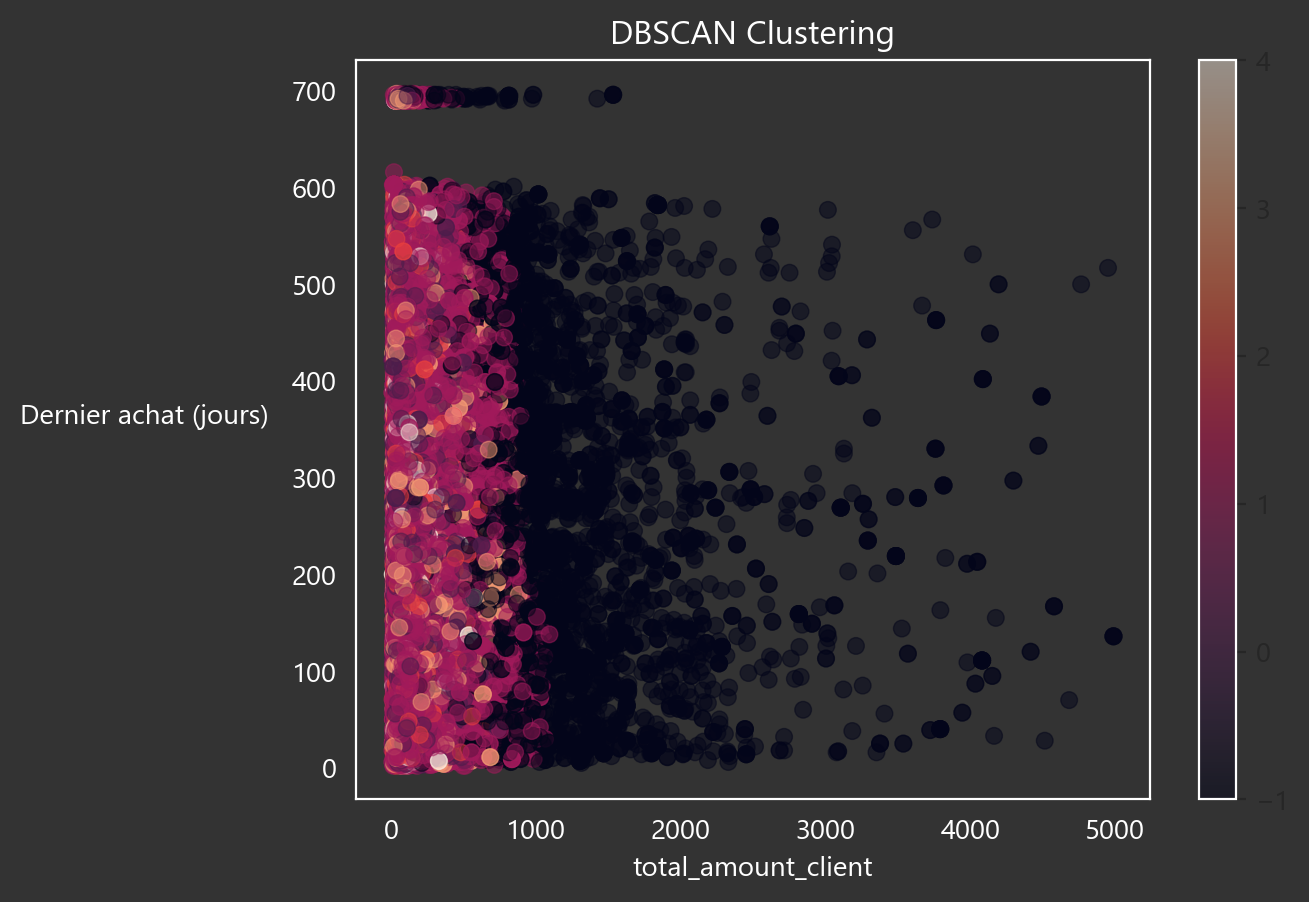

In [116]:
# Afficher les résultats
plt.scatter(data['total_amount_client'], data['days_since_last_purchase'], 
alpha=0.5, linewidths=0.5, c=data["cluster"])
plt.xlabel('total_amount_client', color = 'white')
plt.gca().yaxis.set_label_coords(-0.2666, 0.5)
plt.ylabel('Dernier achat (jours)', color = 'white', rotation = 360)
plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.title("DBSCAN Clustering")
plt.colorbar()
plt.grid(False)
plt.show()

# à la place de la color bar gradient mettre des couleurs distinctes à la place
# avec 4 étiquettes

In [115]:
# Calculer les moyennes des variables pour chaque cluster
cluster_describe = data.groupby('cluster').describe()

# Définir la largeur maximale des colonnes de sortie
pd.set_option('display.width', 110)
# Afficher les moyennes des variables pour chaque cluster
print(cluster_describe)

        review_score                                              payment_installments                      \
               count      mean       std  min  25%  50%  75%  max                count      mean       std   
cluster                                                                                                      
-1            4520.0  3.279646  1.571384  1.0  2.0  4.0  5.0  5.0               4520.0  6.373451  4.208276   
 0           19020.0  4.000000  0.000000  4.0  4.0  4.0  4.0  4.0              19020.0  2.635857  2.418969   
 1           58381.0  5.000000  0.000000  5.0  5.0  5.0  5.0  5.0              58381.0  2.778455  2.571880   
 2            7987.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0               7987.0  2.712908  2.476200   
 3            9556.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0               9556.0  2.886354  2.621981   
 4            2818.0  2.000000  0.000000  2.0  2.0  2.0  2.0  2.0               2818.0  2.521292  2.171165   

         

## SIMULATION 2

In [10]:
# chargement du df master et conversion des variables temporelles au format datetime

df = pd.read_csv('olist_master.csv')

df['order_purchase_datetime'] = pd.to_datetime(df['order_purchase_datetime'])
df['order_delivered_datetime'] = pd.to_datetime(df['order_delivered_datetime'])
df['review_creation_datetime'] = pd.to_datetime(df['review_creation_datetime'])

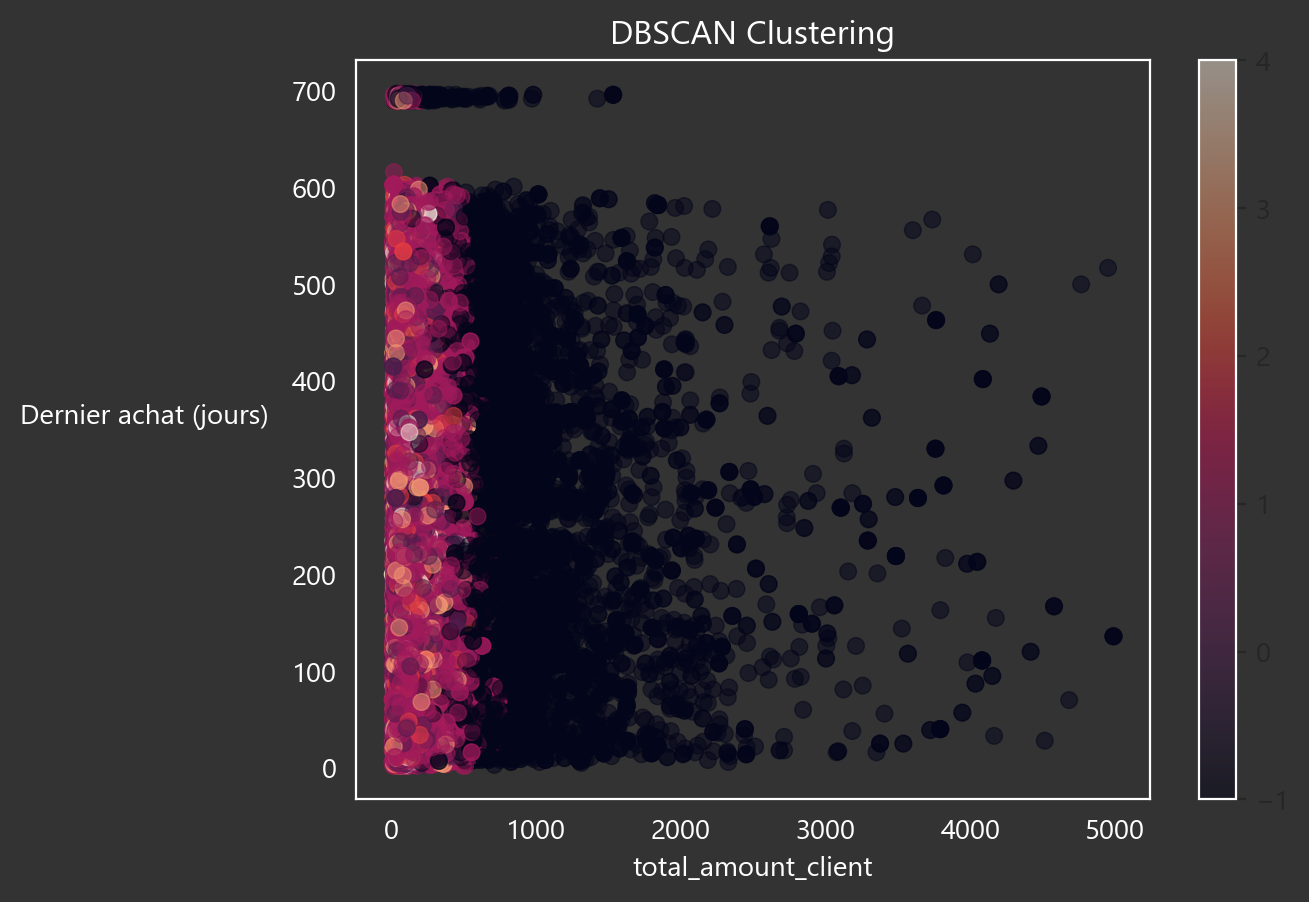

In [118]:
# Sélectionner les colonnes pertinentes pour la segmentation
data = df[['review_score', 'payment_installments', 'total_amount_client', 'price', 'days_since_last_purchase']]

data = data[data['total_amount_client'] <= 6000]

# Normaliser les données numériques
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['review_score', 'payment_installments', 'total_amount_client', 'price', 'days_since_last_purchase']])

# Créer un modèle DBSCAN
dbscan = DBSCAN(eps=0.66, min_samples=100)

# Effectuer la segmentation
clusters = dbscan.fit_predict(scaled_data)

# Ajouter les informations de clustering au DataFrame
data["cluster"] = clusters

# Afficher les résultats
plt.scatter(data['total_amount_client'], data['days_since_last_purchase'], 
alpha=0.5, linewidths=0.5, c=data["cluster"])
plt.xlabel('total_amount_client', color = 'white')
plt.gca().yaxis.set_label_coords(-0.2666, 0.5)
plt.ylabel('Dernier achat (jours)', color = 'white', rotation = 360)
plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.title("DBSCAN Clustering")
plt.colorbar()
plt.grid(False)
plt.show()

# PLOTTER AVEC D'AUTRES VARIABLES
# RAJOUTER L'INERTIE
# chercher une fonction pour les métriques des clusters
# chercher la valeur de la distance (écart intercluster et intra cluster)selon espilon

In [119]:
# Calculer les moyennes des variables pour chaque cluster
cluster_describe = data.groupby('cluster').describe()

# Définir la largeur maximale des colonnes de sortie
pd.set_option('display.width', 110)
# Afficher les moyennes des variables pour chaque cluster
print(cluster_describe)

        review_score                                              payment_installments                      \
               count      mean       std  min  25%  50%  75%  max                count      mean       std   
cluster                                                                                                      
-1            8084.0  3.341539  1.577006  1.0  2.0  4.0  5.0  5.0               8084.0  6.280183  3.925579   
 0           18489.0  4.000000  0.000000  4.0  4.0  4.0  4.0  4.0              18489.0  2.552491  2.324838   
 1           56968.0  5.000000  0.000000  5.0  5.0  5.0  5.0  5.0              56968.0  2.690352  2.473912   
 2            7482.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0               7482.0  2.431703  2.132040   
 3            8811.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0               8811.0  2.637045  2.371206   
 4            2448.0  2.000000  0.000000  2.0  2.0  2.0  2.0  2.0               2448.0  1.981618  1.389460   

         

# Montrer les différences avec DBScan
# Expliquer le choix du nombre de clusters par rapport à kmeans
# pourquoi 4 clusters et pas 6 etc

# DENDOGRAMME

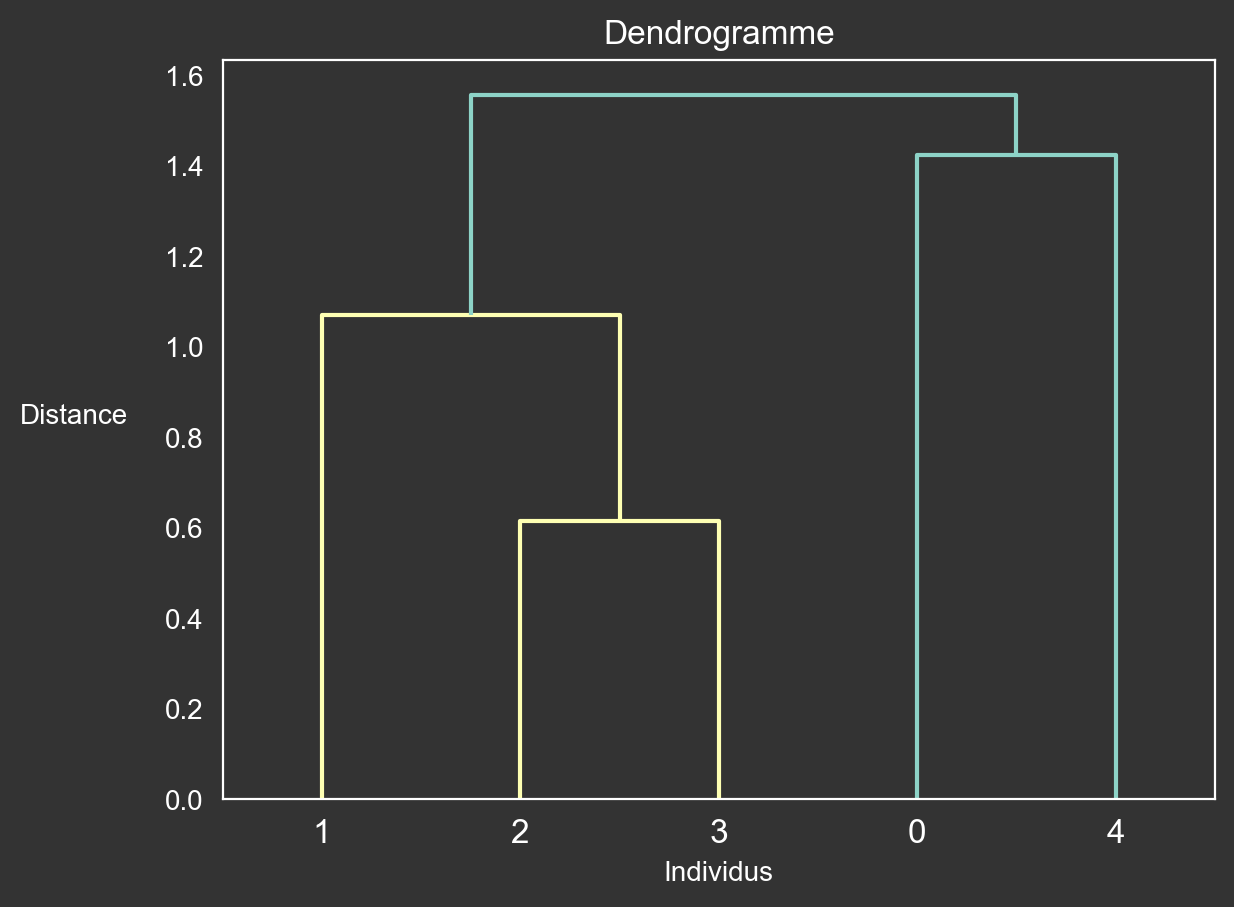

In [10]:
# Chargement des données à partir du fichier CSV
data = df

# Sélection des colonnes pour l'analyse de segmentation de clientèle
selected_columns = ['review_score', 'payment_installments', 'total_amount_client', 'price', 'days_since_last_purchase']

# Extraction des données sélectionnées
selected_data = data[selected_columns]

# Standardisation des données
scaler = StandardScaler()
scaled_data = scaler.fit_transform(selected_data)

# Calcul de la matrice de similarité
similarity_matrix = np.corrcoef(scaled_data.T)

# Calcul du lien hiérarchique
linkage = hierarchy.linkage(similarity_matrix, method='average')

# Construction du dendrogramme
dendrogram = hierarchy.dendrogram(linkage)

# Affichage du dendrogramme
plt.xlabel('Individus', color = 'white')
plt.gca().yaxis.set_label_coords(-0.15, 0.5)
plt.ylabel('Distance', color = 'white', rotation = 360)
plt.title('Dendrogramme')
plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.grid(False)
plt.show()